# GridWorld 2:

*GridWorld* es un mundo en forma de cuadrícula muy utilizado como entorno de pruebas para técnicas de Aprendizaje por Refuerzo. Dentro de esta cuadrícula hay varios tipos de celdas: iniciales, libres, obstáculos, terminales... ¡y ahora también agujeros de gusano! Los agentes tienen que llegar desde una celda inicial hasta otra terminal evitando los obtáculos y recorriendo una distancia mínima.

Paquetes necesarios para *GridWorld 2*:

In [ ]:
import numpy as np
import math

np.random.seed(123)

Funciones auxiliares para visualizar información:

In [ ]:
def printMap(world):
  # Visualiza el mapa de GridWorld
  m = "["
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      if world.map[(i, j)] == 0: 
        m += " O "
      elif world.map[(i, j)] == -1:
        m += " X " 
      elif world.map[(i, j)] == 1:
        m += " F "
      elif world.map[(i, j)] == 2:
        m += " T "
    if i == world.size[0] - 1:
      m += "]\n"
    else:
      m += "\n"
  print(m)

def printPolicy(world, policy):
  # Visualiza la política con flechas
  p = ""
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      color = "\033[0m"
      if world.map[(i, j)] == -1:
        p += color + " # "
      elif world.map[(i, j)] == 1:
        p += color + " @ "
      else:
        if world.map[(i, j)] == 2:
            color = "\033[1;32;40m"
        if policy[i][j] == 0:
            p += color + " ^ "
        elif policy[i][j] == 1:
            p += color + " v "
        elif policy[i][j] == 2:
            p += color + " < "
        else:
            p += color + " > "
    p += "\n"
  print(p)

# Clase *World*: 

Esta clase almacena la información del mundo:

*   *Map*: Matriz con la codificación del mundo con celdas libres (0), obstáculos (-1) y terminales (1)
*   *Size*: Vector con el tamaño de la matriz de codificación del mundo (ancho, alto)

Para crear un mundo hay que aportar los siguientes datos:

*   Tamaño del mapa (ancho, alto)
*   Lista de celdas terminales
*   Lista de celdas con obstáculos
*   Agujero de gusano

Notas:

* Cuando el agente cae en un obstáculo se queda atrapado para siempre en él
* Cuando el agente entra por un extremo del agujero de gusano sale por el otro extremo

Por ejemplo: 

w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])

Crea un mundo de 10 filas y 10 columnas con un estado terminal (9, 9), dos obstáculos en (2, 4) y (4, 2) y un teletransporte entre (0, 2) y (9, 7).

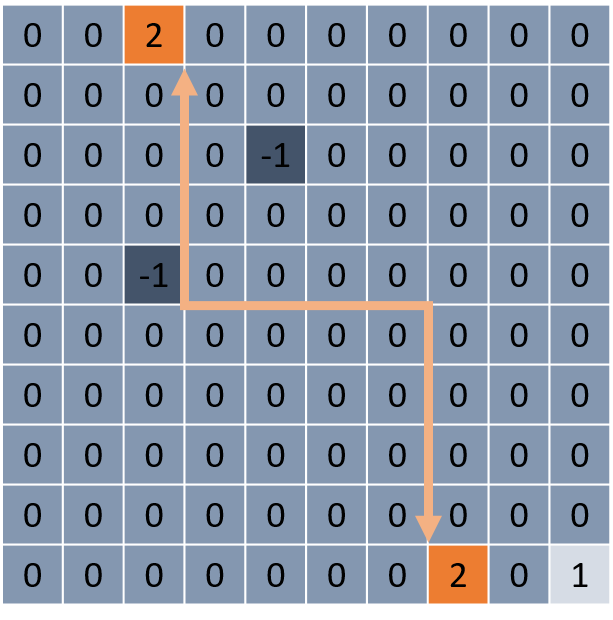

In [ ]:
class World:

  def __init__(self, size, terminal, obstacle, hole):
    # Crea un mundo
    self.size = size
    self.map = {}
    for i in range(size[0]):
      for j in range(size[1]):
        # Estados libres
        self.map[(i, j)] = 0
        # Estados terminales
        for t in terminal:
          if i==t[0] and j==t[1]:
            self.map[(i, j)] = 1
        # Estados con obstáculos
        for o in obstacle:
          if i==o[0] and j==o[1]:
            self.map[(i, j)] = -1
        for h in hole:
          if i==h[0] and j==h[1]:
            self.map[(i, j)] = 2

Prueba de la clase *World*:

In [ ]:
if __name__ == "__main__":
  w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])
  printMap(w)

[ O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F ]



# Clase *Agent*:

Esta clase controla el agente que aprende por refuerzo en *GridWorld*. 

Para crear un agente se necesitan los siguientes datos:

*   *World*: Mundo en el que se desenvuelve el agente.
*   *Initial State*: Estado inicial del agente.

Para controlar el agente se usan los siguientes métodos:

*   *nextState = move(state, action)*: Mueve el agente del estado *state* a un nuevo estado *nextState* aplicando una acción *action*.
*   *reward = reward(nextState)*: Devuelve el refuerzo *reward* que recibe el agente al transicionar al estado *nextState*.
*   *nextState, reward = checkAction(state, action)*: Comprueba a qué estado *nextState* y con qué refuerzo *reward* cambia el agente al aplicar la acción *action* en el estado *state*. Este método no cambia el estado interno del agente, por lo que puede usarse para hacer barridos del espacio de estados.
*   *nextState, reward = executeAction(action)*: Ejecuta la acción *action* en el estado actual y devuelve el nuevo estado *nextState* y el refuerzo *reward*. Este método cambia el estado interno del agente, por lo que sólo debe usarse cuando se realice un recorrido por el mundo.

Nota: Podéis hacer cambios en el agente (distribución de refuerzos, comportamiento en obstáculos...) buscando mejorar el rendimiento de los algoritmos. 

# Clase *Agent_v2*:

Hemos decidido implementar una serie de mejoras sobre el agente base que constan de lo siguiente.

* Mejor comportamiento con obstáculos, rebotando sobre ellos en vez de estancarse, lo que nos permite hacer las iteraciones de entrenamiento de forma que la condición de parada es que llega al final.

* Cambio en la valoración de los refuerzos, donde hemos decidido aplicar una penalización a casillas libres, con la esperanza de penalizar que al agente haga *backtracking*, aunque en cierto modo también puede implicar que el agente se desvíe en futuras iteraciones, porque premiamos la exploración de casillas no antes pasadas.

In [ ]:
class Agent:

  def __init__(self, world, initialState):
    # Crea un agente
    self.world = world
    self.state = np.array(initialState)

  def move(self, state, action):
    # Gestiona las transiciones de estados
    nextState = state + np.array(action)
    if nextState[0] < 0:
      nextState[0] = 0
    elif nextState[0] >= self.world.size[0]:
      nextState[0] = self.world.size[0] - 1
    if nextState[1] < 0:
      nextState[1] = 0
    elif nextState[1] >= self.world.size[1]:
      nextState[1] = self.world.size[1] - 1
    if self.world.map[(nextState[0], nextState[1])] == 2:
      aux = nextState
      for i in range(self.world.size[0]):
        for j in range(self.world.size[1]):
          if self.world.map[(i, j)] == 2 and (nextState[0] != i and nextState[1] != j):
            aux = np.array([i, j])
      nextState = aux
    return nextState

  def reward(self, nextState):
    # Gestiona los refuerzos
    if self.world.map[(nextState[0], nextState[1])] == -1:
      # Refuerzo cuando el agente intenta moverse a un obstáculo
      reward = -1 # ** Prueba varios valores **
    elif self.world.map[(nextState[0], nextState[1])] == 1:
      # Refuerzo cuando el agente se mueve a una celda terminal
      reward = 1 # ** Prueba varios valores **
    else:
      # Refuerzo cuando el agente se mueve a una celda libre
      reward = 0 # ** Prueba varios valores ** 
    return reward

  def checkAction(self, state, action):
    # Planifica una acción
    nextState = self.move(state, action)
    reward = self.reward(nextState)
    if self.world.map[(state[0], state[1])] == -1: 
      nextState = state                          
    return nextState, reward

  def executeAction(self, action):
    # Planifica y ejecuta una acción
    nextState = self.move(self.state, action)
    if self.world.map[(self.state[0], self.state[1])] == -1: 
      nextState = self.state     
    else: 
      self.state = nextState                                 
    reward = self.reward(nextState)
    return self.state, reward  

In [ ]:
class Agent_v2:

  def __init__(self, world, initialState):
    # Crea un agente
    self.world = world
    self.state = np.array(initialState)

  def move(self, state, action):
    # Gestiona las transiciones de estados
    nextState = state + np.array(action)
    if nextState[0] < 0:
      nextState[0] = 0
    elif nextState[0] >= self.world.size[0]:
      nextState[0] = self.world.size[0] - 1
    if nextState[1] < 0:
      nextState[1] = 0
    elif nextState[1] >= self.world.size[1]:
      nextState[1] = self.world.size[1] - 1
    if self.world.map[(nextState[0], nextState[1])] == 2:
      aux = nextState
      for i in range(self.world.size[0]):
        for j in range(self.world.size[1]):
          if self.world.map[(i, j)] == 2 and (nextState[0] != i and nextState[1] != j):
            aux = np.array([i, j])
      nextState = aux
    return nextState

  def reward(self, nextState):
    # Gestiona los refuerzos
    if self.world.map[(nextState[0], nextState[1])] == -1:
      # Refuerzo cuando el agente intenta moverse a un obstáculo
      reward = -2 # ** Prueba varios valores **
    elif self.world.map[(nextState[0], nextState[1])] == 1:
      # Refuerzo cuando el agente se mueve a una celda terminal
      reward = 1 # ** Prueba varios valores **
    else:
      # Refuerzo cuando el agente se mueve a una celda libre
      reward = -0.1 # ** Prueba varios valores ** 
    return reward

  def checkAction(self, state, action):
    # Planifica una acción
    nextState = self.move(state, action)
    reward = self.reward(nextState)
    if self.world.map[(nextState[0], nextState[1])] == -1: 
      nextState = state                          
    return nextState, reward

  def executeAction(self, action):
    # Planifica y ejecuta una acción
    nextState = self.move(self.state, action)
    reward = self.reward(nextState)
    if self.world.map[(nextState[0], nextState[1])] == -1: 
      nextState = self.state     
    else: 
      self.state = nextState                                 
    return self.state, reward  

Prueba de la clase *Agent*:

In [ ]:
if __name__ == "__main__":
  # Crear el mundo
  w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])
  printMap(w)
  # Crear el agente
  a = Agent(w, (0, 0))
  # Mover el agente en la diagonal principal
  for i in range(1, 5):
    # Mostrar cada nuevo estado y su recompensa
    print(a.executeAction((0, 1)))

[ O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F ]

(array([0, 1]), 0)
(array([9, 7]), 0)
(array([9, 8]), 0)
(array([9, 9]), 1)


# Trabajo:

En este trabajo vais a implementar los dos algoritmos más comunes de aprendizaje por refuerzo basados en el valor: SARSA y QLearning. Además, vais a probar ambos algoritmos en una serie de escenarios para evaluar su funcionamiento y comparar sus resultados.

## Mundos: 

Para probar los algoritmos se ofrecen los siguientes mundos en varios tamaños:

*   Mundo 1: Laberinto fácil que se puede recorrer en zigzag
*   Mundo 2: Mundo con obstáculos aleatorios en el que el teletransporte acorta la distancia desde el inicio hasta el final
*   Mundo 3: Mundo con obstáculos aleatorios en el que el teletransporte no reduce la distancia desde el inicio hasta el final
*   Mundo 4: Laberinto difícil con caminos correctos y equivocados

Nota: Sentíos libres de utilizar todos o algunos de estos escenarios o directamente crear vuestros propios escenarios.

In [ ]:
if __name__ == "__main__":
  
  # Mundo 1 pequeño: Laberinto fácil
  obstacles = []
  for j in range(0, 4):
    obstacles.append((j, 1))
  for j in range(1, 5):
    obstacles.append((j, 3))
  w1p = World((5, 5), [(4, 4)], obstacles, [])
  print("World 1: ")
  printMap(w1p)

  # Mundo 1 mediano: Laberinto fácil
  obstacles = []
  for i in [1, 5]:
    for j in range(0, 8):
      obstacles.append((j, i))
  for i in [3, 7]:
    for j in range(1, 9):
      obstacles.append((j, i))
  w1m = World((9, 9), [(8, 8)], obstacles, [])
  print("World 1: ")
  printMap(w1m)

  # Mundo 1 grande: Laberinto fácil
  obstacles = []
  for i in [1, 5, 9, 13, 17]:
    for j in range(0, 20):
      obstacles.append((j, i))
  for i in [3, 7, 11, 15, 19]:
    for j in range(1, 21):
      obstacles.append((j, i))
  w1g = World((21, 21), [(20, 20)], obstacles, [])
  print("World 1: ")
  printMap(w1g)

  # Mundo 2 pequeño: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(3):
    obstacles.append((np.random.randint(1, 4), np.random.randint(1, 4)))  
  w2p = World((5, 5), [(4, 4)], obstacles, [(2, 0), (4, 2)])
  print("World 2: ")
  printMap(w2p)

  # Mundo 2 mediano: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(10):
    obstacles.append((np.random.randint(1, 9), np.random.randint(1, 9)))  
  w2m = World((10, 10), [(9, 9)], obstacles, [(3, 1), (8, 6)])
  print("World 2: ")
  printMap(w2m)

  # Mundo 2 grande: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(50):
    obstacles.append((np.random.randint(1, 19), np.random.randint(1, 19)))  
  w2g = World((21, 21), [(20, 20)], obstacles, [(6, 2), (18, 14)])
  print("World 2: ")
  printMap(w2g)

  # Mundo 3 pequeño: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(3):
    obstacles.append((np.random.randint(1, 4), np.random.randint(1, 4)))  
  w3p = World((5, 5), [(4, 4)], obstacles, [(4, 0), (0, 4)])
  print("World 3: ")
  printMap(w3p)

  # Mundo 3 mediano: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(10):
    obstacles.append((np.random.randint(1, 9), np.random.randint(1, 9)))  
  w3m = World((10, 10), [(9, 9)], obstacles, [(8, 1), (1, 8)])
  print("World 3: ")
  printMap(w3m)

  # Mundo 3 grande: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(50):
    obstacles.append((np.random.randint(1, 19), np.random.randint(1, 19)))  
  w3g = World((21, 21), [(20, 20)], obstacles, [(18, 2), (2, 18)])
  print("World 3: ")
  printMap(w3g)

  # Mundo 4: Laberinto difícil
  obstacles = [(0,1),(0,3),(0,9),(0,15),(0,16),(0,17),(0,19),
               (1,1),(1,3),(1,4),(1,5),(1,6),(1,7),(1,9),(1,10),(1,11),(1,12),(1,13),(1,17),(1,19),
               (2,1),(2,9),(2,13),(2,15),(2,16),(2,17),(2,19),
               (3,1),(3,3),(3,5),(3,7),(3,9),(3,11),(3,16),(3,19),
               (4,3),(4,5),(4,7),(4,8),(4,9),(4,10),(4,11),(4,12),(4,13),(4,14),(4,16),(4,18),(4,19),
               (5,0),(5,1),(5,2),(5,3),(5,5),(5,9),(5,16),
               (6,5),(6,6),(6,7),(6,9),(6,10),(6,11),(6,12),(6,13),(6,14),(6,16),(6,17),(6,19),
               (7,0),(7,1),(7,2),(7,3),(7,5),(7,7),(7,9),(7,19),
               (8,3),(8,7),(8,8),(8,9),(8,12),(8,13),(8,14),(8,15),(8,16),(8,17),(8,18),(8,19),
               (9,1),(9,3),(9,5),(9,7),(9,11),(9,12),(9,19),(9,20),
               (10,1),(10,3),(10,5),(10,6),(10,7),(10,9),(10,11),(10,14),(10,15),(10,16),(10,17),
               (11,1),(11,3),(11,5),(11,9),(11,11),(11,13),(11,14),(11,17),(11,18),(11,19),
               (12,1),(12,5),(12,6),(12,8),(12,9),(12,11),(12,13),(12,19),
               (13,1),(13,2),(13,3),(13,4),(13,5),(13,8),(13,15),(13,16),(13,17),(13,19),
               (14,4),(14,7),(14,8),(14,10),(14,12),(14,13),(14,15),(14,19),
               (15,0),(15,1),(15,2),(15,6),(15,7),(15,10),(15,13),(15,14),(15,15),(15,17),(15,18),(15,19),(15,20),
               (16,2),(16,3),(16,5),(16,6),(16,7),(16,8),(16,9),(16,10),(16,11),(16,15),(16,17),
               (17,0),(17,3),(17,5),(17,9),(17,13),(17,14),(17,15),(17,17),(17,19),
               (18,0),(18,1),(18,5),(18,6),(18,7),(18,9),(18,10),(18,11),(18,15),(18,19),
               (19,1),(19,2),(19,4),(19,5),(19,11),(19,13),(19,14),(19,15),(19,16),(19,17),(19,18),(19,19),
               (20,7),(20,8),(20,9),(20,11),(20,19)]          
  print("World 4: ")
  w4 = World((21, 21), [(20, 20)], obstacles, [])
  printMap(w4)

World 1: 
[ O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

World 1: 
[ O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

World 1: 
[ O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  

In [ ]:
def test_convergence(Q, agent, actions):

  state = agent.state
  world = agent.world
  total_reward = 0


  for path_length in range(world.size[0] * world.size[1]):
    if world.map[state[0], state[1]] == 1:
      return True, path_length, total_reward

    action_i = np.argmax(Q[state[0], state[1], :])
    action = actions[action_i]

    state, reward = agent.checkAction(state, action)
    
    total_reward += reward

  return False, 0, 0

## SARSA:

*SARSA* (State-Action-Reward-State-Action) es un método basado en el valor que permite resolver problemas de aprendizaje por refuerzo. Al igual que el resto de métodos basados en el valor, *SARSA* calcula de forma iterativa la función de valor $Q(S,A)$ y, a partir de ella, determina la política óptima $\pi$.

*SARSA* recibe su nombre de las cinco variables implicadas en su función de actualización: el estado actual ($S_t$), la acción actual ($A_t$), el refuerzo actual ($R_t$), el siguiente estado ($S_{t+1}$) y la siguiente acción ($A_{t+1}$). Esta función de actualización tiene la siguiente forma:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t,A_t)]
\end{equation}

Nota: $\alpha$ es la longitud del episodio y $\gamma$ el factor de descuento.

El algoritmo *SARSA* sigue el siguiente esquema: 

1.   Inicializar $Q(S,A)$ para todos los estados y acciones 
2.   **Bucle** (repetir $3-9$ hasta la convergencia):
3.   Inicializar $S_t$
4.   Elegir $A_t$ en $S_t$ siguiendo la política derivada de $Q(S,A)$
5.   **Bucle** (repetir $6-9$ hasta que $S_t$ sea terminal):
6.   Tomar la acción $A_t$ en $S_t$ y observar $R_t$ y $S_{t+1}$
7.   Elegir $A_{t+1}$ en $S_{t+1}$ siguiendo la política derivada de $Q(S,A)$
8.   Actualizar el valor $Q(S_t, A_t)$ con la función de actualización
9.   Tomar $S_{t+1}$ y $A_{t+1}$ como los nuevos $S_t$ y $A_t$

El algoritmo *SARSA* utiliza un parámetro $\epsilon \in (0, 1)$ para buscar un equilibrio entre exploración y explotación. A la hora de elegir $A_t$ en $S_t$, si un número aleatorio es menor que $\epsilon$, el algoritmo tomará una acción aleatoria; mientras que si ese número aleatorio es mayor que $\epsilon$, el algoritmo tomará la mejor acción conocida.

## Ejercicio 1:

Implementad el algoritmo SARSA para el agente y entorno definidos anteriormente.

In [ ]:
def SARSA(agent, actions, alpha, gamma, epsilon, n_episodes=1000):

  Q = np.zeros((*agent.world.size, len(actions)))
  converged = False
  rng = np.random.default_rng(123)
  initial_state = agent.state

  for i in range(n_episodes):
    
    agent.state = initial_state
    S_t = agent.state

    actions_value = Q[S_t[0], S_t[1], :]

    if rng.random() < epsilon:
      A_aux = rng.choice(len(actions))
    else:
      A_aux = rng.choice(
          np.where(actions_value == np.max(actions_value))[0])
    
    A_t = actions[A_aux]

    for j in range(1000):

      if agent.world.map[(S_t[0], S_t[1])] in [1, -1]:
        break
      
      nextState, reward = agent.checkAction(S_t, A_t)
      actions_value = Q[nextState[0], nextState[1], :]
      if rng.random() < epsilon:
        A_auxplus1 = rng.choice(len(actions))
      else:
        A_auxplus1 = rng.choice(
          np.where(actions_value == np.max(actions_value))[0])
    
      A_tplus1 = actions[A_auxplus1]

      Q[S_t[0], S_t[1], A_aux] += alpha*(reward + gamma*Q[nextState[0], nextState[1], A_auxplus1] - Q[S_t[0], S_t[1], A_aux])

      S_t = nextState
      A_t = A_tplus1
      A_aux = A_auxplus1

    converged, path_length, total_reward = test_convergence(Q, agent, actions)

    if converged:
      print(f"Convergence reached at episode {i}. Path length: {path_length}. Accumulated reward: {total_reward}")
      return agent, Q

  print(f"Convergence not reached after {n_episodes} episodes")

  return agent, Q

In [ ]:
agent = Agent(w1p, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0.1)
policy = np.zeros(w1p.size, dtype = np.int8)
for i in range(w1p.size[0]):
  for j in range(w1p.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w1p, policy)

Convergence reached at episode 60. Path length: 16. Accumulated reward: 1
 v  #  >  >  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 >  >  ^  #  @ 



In [ ]:
agent = Agent(w1m, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0, n_episodes=1000)
policy = np.zeros(w1m.size, dtype = np.int8)
for i in range(w1m.size[0]):
  for j in range(w1m.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w1m, policy)

Convergence reached at episode 223. Path length: 48. Accumulated reward: 1
 v  #  >  >  v  #  >  >  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 >  >  ^  #  >  >  ^  #  @ 



In [ ]:
agent = Agent(w1g, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0.01, n_episodes=50000)
policy = np.zeros(w1g.size, dtype = np.int8)
for i in range(w1g.size[0]):
  for j in range(w1g.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w1g, policy)

Convergence reached at episode 38212. Path length: 240. Accumulated reward: 1
 v  #  >  >  v  #  >  >  v  #  >  >  v  #  >  >  v  #  >  >  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v

In [ ]:
agent = Agent(w2p, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0)
policy = np.zeros(w2p.size, dtype = np.int8)
for i in range(w2p.size[0]):
  for j in range(w2p.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w2p, policy)

Convergence reached at episode 9. Path length: 4. Accumulated reward: 1
 v  ^  ^  ^  ^ 
 v  ^  ^  #  ^ 
 ^  <  ^  ^  ^ 
 ^  ^  #  #  ^ 
 ^  ^  >  >  @ 



In [ ]:
agent = Agent(w2m, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0, n_episodes=100)
policy = np.zeros(w2m.size, dtype = np.int8)
for i in range(w2m.size[0]):
  for j in range(w2m.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w2m, policy)

Convergence reached at episode 42. Path length: 8. Accumulated reward: 1
 v  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 v  <  #  ^  ^  ^  ^  ^  ^  ^ 
 v  #  v  ^  ^  ^  ^  ^  ^  ^ 
 >  v  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  #  #  ^  ^  ^  #  ^  ^ 
 ^  ^  v  v  ^  ^  v  v  ^  ^ 
 ^  ^  ^  ^  ^  ^  v  ^  ^  ^ 
 ^  #  #  ^  ^  ^  >  v  #  ^ 
 ^  ^  #  ^  ^  ^  v  v  v  v 
 ^  ^  v  ^  ^  ^  >  >  >  @ 



In [ ]:
agent = Agent(w2g, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0, n_episodes=1000)
policy = np.zeros(w2g.size, dtype = np.int8)
for i in range(w2g.size[0]):
  for j in range(w2g.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w2g, policy)

Convergence reached at episode 184. Path length: 22. Accumulated reward: 1
 >  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  v  >  v  #  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  v  >  v  <  #  ^  ^  ^  ^  ^  ^  #  #  ^  ^  #  ^  ^  ^  ^ 
 ^  v  #  v  #  v  ^  ^  #  ^  ^  ^  <  <  ^  ^  #  ^  ^  ^  ^ 
 ^  >  >  v  #  ^  ^  ^  v  ^  ^  #  #  #  ^  ^  v  ^  ^  ^  ^ 
 ^  #  v  v  v  ^  ^  ^  ^  ^  ^  v  v  v  ^  ^  #  ^  ^  ^  ^ 
 ^  #  ^  <  ^  ^  ^  ^  ^  #  ^  ^  ^  ^  ^  ^  v  ^  #  ^  ^ 
 ^  v  #  ^  ^  ^  ^  ^  ^  v  #  ^  ^  #  #  ^  ^  ^  #  ^  ^ 
 ^  ^  v  ^  ^  ^  ^  #  ^  ^  #  ^  ^  v  v  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  v  ^  ^  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  #  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  #  ^  ^  ^ 
 ^  ^  ^  ^  <  ^  ^  ^  ^  ^  ^  ^  ^  ^  #  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  #  #  ^  ^  ^  #  ^  ^  ^  ^  #  v  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  v  v  #  ^  ^  v  #  ^  ^  ^  v  ^  ^  ^  ^  #  ^  ^ 
 ^  ^  ^  ^  ^  v  ^  ^  ^  v

In [ ]:
agent = Agent(w3p, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0, n_episodes=100)
policy = np.zeros(w3p.size, dtype = np.int8)
for i in range(w3p.size[0]):
  for j in range(w3p.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w3p, policy)

Convergence reached at episode 16. Path length: 8. Accumulated reward: 1
 v  ^  ^  ^  v 
 v  #  ^  ^  v 
 v  #  >  >  v 
 v  <  ^  ^  v 
 ^  ^  ^  ^  @ 



In [ ]:
agent = Agent(w3m, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0, n_episodes=100)
policy = np.zeros(w3m.size, dtype = np.int8)
for i in range(w3m.size[0]):
  for j in range(w3m.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w3m, policy)

Convergence reached at episode 77. Path length: 18. Accumulated reward: 1
 >  >  >  >  >  v  ^  ^  v  ^ 
 ^  ^  >  ^  ^  >  >  >  ^  ^ 
 ^  ^  ^  #  ^  ^  ^  #  ^  ^ 
 ^  ^  ^  v  ^  ^  #  v  #  ^ 
 ^  ^  #  ^  ^  ^  v  ^  v  ^ 
 ^  ^  v  ^  v  #  >  >  v  < 
 ^  #  v  ^  v  v  ^  ^  v  < 
 ^  #  v  ^  >  v  ^  #  >  v 
 ^  v  v  #  ^  v  ^  v  ^  v 
 >  >  >  >  >  >  >  >  >  @ 



In [ ]:
agent = Agent(w3g, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0, n_episodes=1000)
policy = np.zeros(w3g.size, dtype = np.int8)
for i in range(w3g.size[0]):
  for j in range(w3g.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w3g, policy)

Convergence reached at episode 312. Path length: 42. Accumulated reward: 1
 >  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 v  v  ^  ^  #  ^  ^  ^  #  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 >  v  v  #  #  v  #  ^  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  >  >  >  >  v  #  ^  ^  ^  ^  #  ^  ^  #  ^  ^  ^  ^  ^  ^ 
 ^  ^  #  >  >  v  <  ^  ^  ^  ^  v  #  ^  #  #  ^  ^  #  ^  ^ 
 ^  v  >  ^  #  v  #  ^  ^  #  ^  ^  v  #  v  v  ^  ^  v  ^  ^ 
 ^  v  #  #  v  v  v  ^  ^  v  #  ^  ^  v  ^  ^  ^  ^  ^  ^  ^ 
 >  >  >  >  >  v  <  <  ^  ^  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  #  v  ^  #  ^  ^  ^  ^  ^  #  #  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  v  v  ^  v  ^  ^  #  ^  ^  v  v  #  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  >  v  ^  ^  ^  ^  v  ^  ^  ^  ^  #  #  ^  #  ^  ^ 
 ^  ^  ^  ^  >  v  ^  ^  #  #  ^  ^  ^  ^  ^  v  v  ^  v  ^  ^ 
 ^  ^  ^  ^  ^  v  v  ^  v  v  ^  #  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  #  ^  ^  v  >  v  ^  v  ^  v  ^  ^  ^  ^  ^  >  v  ^  ^ 
 ^  ^  v  ^  >  >  ^  >  >  v

In [ ]:
agent = Agent(w4, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0.01, n_episodes=10000)
policy = np.zeros(w4.size, dtype = np.int8)
for i in range(w4.size[0]):
  for j in range(w4.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w4, policy)

Convergence reached at episode 4814. Path length: 82. Accumulated reward: 1
 v  #  ^  #  >  >  >  <  <  #  >  <  <  <  <  #  #  #  v  #  ^ 
 v  #  ^  #  #  #  #  #  ^  #  #  #  #  #  ^  <  <  #  v  #  ^ 
 v  #  >  >  v  <  <  >  v  #  v  >  v  #  ^  #  #  #  v  #  ^ 
 v  #  ^  #  v  #  ^  #  ^  #  ^  #  >  >  ^  <  #  v  <  #  ^ 
 >  >  ^  #  v  #  ^  #  #  #  #  #  #  #  #  ^  #  v  #  #  v 
 #  #  #  #  v  #  ^  <  <  #  >  >  >  >  >  ^  #  >  >  >  ^ 
 >  >  >  >  v  #  #  #  ^  #  #  #  #  #  #  ^  #  #  ^  #  ^ 
 #  #  #  #  v  #  v  #  ^  #  >  >  >  >  >  >  >  >  ^  #  ^ 
 v  <  <  #  v  <  <  #  #  #  ^  ^  #  #  #  #  #  #  #  #  ^ 
 v  #  ^  #  v  #  ^  #  >  >  v  #  #  >  <  <  <  <  <  #  # 
 v  #  ^  #  v  #  #  #  ^  #  v  #  >  ^  #  #  #  #  ^  <  < 
 v  #  ^  #  v  #  >  >  ^  #  v  #  ^  #  #  v  <  #  #  #  ^ 
 v  #  ^  <  <  #  #  ^  #  #  v  #  ^  #  >  >  >  >  v  #  ^ 
 v  #  #  #  #  #  >  ^  #  v  >  >  >  >  ^  #  #  #  v  #  ^ 
 >  >  >  v  #  >  ^  #  #  

# Pruebas SARSA con la nueva versión de agente

In [ ]:
agent = Agent_v2(w1p, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0.1)
policy = np.zeros(w1p.size, dtype = np.int8)
for i in range(w1p.size[0]):
  for j in range(w1p.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w1p, policy)

Convergence reached at episode 47. Path length: 16. Accumulated reward: -0.5000000000000002
 v  #  >  >  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 >  >  ^  #  @ 



In [ ]:
agent = Agent_v2(w1m, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0.1, n_episodes=10000)
policy = np.zeros(w1m.size, dtype = np.int8)
for i in range(w1m.size[0]):
  for j in range(w1m.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w1m, policy)

Convergence reached at episode 319. Path length: 48. Accumulated reward: -3.6999999999999993
 v  #  >  >  v  #  >  >  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 >  >  ^  #  >  >  ^  #  @ 



In [ ]:
agent = Agent_v2(w1g, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0.01, n_episodes=50000)
policy = np.zeros(w1g.size, dtype = np.int8)
for i in range(w1g.size[0]):
  for j in range(w1g.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w1g, policy)

Convergence reached at episode 2089. Path length: 240. Accumulated reward: -22.90000000000007
 v  #  >  >  v  #  >  >  v  #  >  >  v  #  >  >  v  #  >  >  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  

In [ ]:
agent = Agent_v2(w2p, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0)
policy = np.zeros(w2p.size, dtype = np.int8)
for i in range(w2p.size[0]):
  for j in range(w2p.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w2p, policy)

Convergence reached at episode 7. Path length: 4. Accumulated reward: 0.7
 v  >  <  >  v 
 v  >  v  #  v 
 v  >  <  <  v 
 v  ^  #  #  v 
 v  ^  >  >  @ 



In [ ]:
agent = Agent_v2(w2m, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0, n_episodes=100)
policy = np.zeros(w2m.size, dtype = np.int8)
for i in range(w2m.size[0]):
  for j in range(w2m.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w2m, policy)

Convergence reached at episode 28. Path length: 8. Accumulated reward: 0.30000000000000004
 v  ^  >  <  v  <  v  <  ^  < 
 v  ^  #  v  <  v  v  >  >  > 
 v  #  >  <  v  ^  >  ^  ^  v 
 >  <  >  ^  v  v  >  >  <  ^ 
 >  ^  #  #  v  v  ^  #  >  < 
 v  <  v  <  <  ^  <  <  <  v 
 ^  ^  <  v  <  >  <  >  ^  v 
 ^  #  #  >  v  >  v  <  #  v 
 >  <  #  v  >  v  v  v  v  v 
 <  <  <  v  v  <  >  >  >  @ 



In [ ]:
agent = Agent_v2(w2g, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0, n_episodes=1000)
policy = np.zeros(w2g.size, dtype = np.int8)
for i in range(w2g.size[0]):
  for j in range(w2g.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w2g, policy)

Convergence reached at episode 115. Path length: 16. Accumulated reward: -0.5000000000000002
 v  >  <  <  >  ^  v  <  <  ^  ^  ^  <  v  >  ^  >  >  ^  >  > 
 >  v  >  ^  #  ^  >  >  <  <  >  <  <  <  <  ^  ^  v  ^  ^  ^ 
 <  v  <  <  <  #  >  ^  ^  >  v  <  #  #  ^  ^  #  v  >  v  ^ 
 ^  v  #  ^  #  >  >  v  #  v  v  <  <  <  ^  ^  #  >  ^  <  v 
 v  >  v  ^  #  v  ^  ^  v  ^  <  #  #  #  v  >  <  >  v  ^  > 
 v  #  v  >  <  v  >  ^  <  >  v  v  >  <  >  <  #  >  <  >  v 
 <  #  ^  <  <  v  <  v  v  #  ^  <  v  >  <  ^  <  v  #  v  > 
 >  v  #  >  <  v  <  >  >  v  #  v  ^  #  #  >  ^  v  #  v  > 
 v  <  v  ^  ^  >  v  #  >  <  #  ^  ^  <  >  ^  ^  ^  <  >  v 
 ^  >  <  >  ^  >  <  <  <  v  v  v  v  <  ^  >  v  >  v  >  ^ 
 v  <  <  ^  #  >  v  <  <  v  <  v  >  ^  >  ^  <  #  v  <  ^ 
 <  >  <  <  <  >  <  >  ^  <  >  >  <  <  #  ^  <  v  <  ^  > 
 v  <  <  #  #  ^  <  v  #  >  >  >  ^  #  >  v  ^  ^  <  >  ^ 
 >  <  <  <  <  #  ^  >  v  #  >  >  >  v  ^  ^  ^  ^  #  v  < 
 v  >  <  >

In [ ]:
agent = Agent_v2(w3p, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0, n_episodes=100)
policy = np.zeros(w3p.size, dtype = np.int8)
for i in range(w3p.size[0]):
  for j in range(w3p.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w3p, policy)

Convergence reached at episode 21. Path length: 10. Accumulated reward: 0.10000000000000009
 >  >  >  v  > 
 ^  #  v  <  v 
 v  #  v  v  v 
 ^  v  v  v  v 
 <  >  >  >  @ 



In [ ]:
agent = Agent_v2(w3m, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0, n_episodes=1000)
policy = np.zeros(w3m.size, dtype = np.int8)
for i in range(w3m.size[0]):
  for j in range(w3m.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w3m, policy)

Convergence reached at episode 115. Path length: 24. Accumulated reward: -1.3000000000000007
 >  v  >  >  >  ^  >  >  ^  < 
 <  v  v  >  v  ^  ^  <  <  ^ 
 ^  >  v  #  >  ^  <  #  ^  v 
 ^  v  <  <  ^  <  #  ^  #  v 
 ^  v  #  >  >  >  v  v  >  v 
 ^  >  v  >  ^  #  >  >  >  v 
 <  #  >  ^  >  >  v  >  >  v 
 ^  #  >  >  >  v  v  #  >  v 
 ^  >  <  #  v  >  v  v  >  v 
 v  >  >  >  >  >  >  >  >  @ 



In [ ]:
agent = Agent_v2(w3g, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0, n_episodes=10000)
policy = np.zeros(w3g.size, dtype = np.int8)
for i in range(w3g.size[0]):
  for j in range(w3g.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w3g, policy)

Convergence reached at episode 966. Path length: 42. Accumulated reward: -3.1000000000000014
 v  v  ^  ^  <  v  <  ^  v  >  v  >  v  v  >  v  >  ^  ^  >  ^ 
 v  v  >  v  #  v  >  v  #  >  ^  >  >  >  >  >  v  >  >  v  < 
 v  >  v  #  #  v  #  >  <  >  >  <  <  >  >  >  >  ^  <  >  < 
 v  >  <  v  >  <  #  ^  v  >  ^  #  ^  v  #  ^  <  ^  >  v  < 
 v  v  #  >  >  >  >  v  <  >  >  <  #  ^  #  #  >  v  #  ^  v 
 >  >  >  ^  #  v  #  >  v  #  ^  v  v  #  >  >  >  <  >  v  v 
 v  v  #  #  >  v  <  v  >  v  #  >  >  >  >  ^  v  v  >  v  v 
 >  v  >  v  ^  v  <  ^  >  >  v  >  ^  <  >  v  >  v  >  v  v 
 v  >  ^  ^  #  >  <  #  ^  ^  >  >  v  #  #  >  >  v  >  v  v 
 ^  v  <  >  >  v  ^  >  ^  ^  #  >  v  v  v  #  >  v  >  v  v 
 v  ^  >  >  ^  <  >  v  <  >  >  >  v  v  v  #  #  v  #  >  v 
 v  <  <  v  >  <  v  v  #  #  v  >  >  >  >  v  >  v  v  v  v 
 ^  >  <  v  v  >  v  >  >  v  v  #  >  >  >  v  v  v  v  v  v 
 ^  v  #  ^  v  v  ^  <  >  >  v  v  >  >  >  >  >  >  v  v  v 
 v  <  >  >

In [ ]:
agent = Agent_v2(w4, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=0.01, n_episodes=20000)
policy = np.zeros(w4.size, dtype = np.int8)
for i in range(w4.size[0]):
  for j in range(w4.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w4, policy)

Convergence reached at episode 602. Path length: 82. Accumulated reward: -7.099999999999987
 v  #  v  #  >  <  <  <  <  #  ^  ^  v  <  ^  #  #  #  ^  #  > 
 v  #  ^  #  #  #  #  #  ^  #  #  #  #  #  ^  >  <  #  ^  #  > 
 v  #  >  >  v  >  v  >  ^  #  >  <  <  #  ^  #  #  #  ^  #  > 
 v  #  ^  #  v  #  v  #  ^  #  ^  #  ^  <  <  <  #  >  ^  #  > 
 >  >  ^  #  v  #  v  #  #  #  #  #  #  #  #  ^  #  ^  #  #  > 
 #  #  #  #  v  #  >  >  v  #  <  <  <  v  <  ^  #  ^  >  >  v 
 <  ^  <  <  v  #  #  #  <  #  #  #  #  #  #  ^  #  #  ^  #  v 
 #  #  #  #  v  #  v  #  ^  #  v  <  >  >  >  >  >  >  ^  #  > 
 v  <  <  #  v  >  ^  #  #  #  ^  ^  #  #  #  #  #  #  #  #  ^ 
 v  #  ^  #  v  #  >  #  >  >  v  #  #  >  >  >  >  >  v  #  # 
 v  #  ^  #  v  #  #  #  ^  #  v  #  >  ^  #  #  #  #  >  >  v 
 v  #  ^  #  v  #  >  >  ^  #  v  #  ^  #  #  >  v  #  #  #  > 
 v  #  ^  <  <  #  #  ^  #  #  v  #  v  #  >  >  >  >  v  #  > 
 v  #  #  #  #  #  >  ^  #  >  >  >  >  >  ^  #  #  #  v  #  v 
 >  >  >  v 

## Q-Learning:

*Q-Learning* es el método más conocido para resolver problemas de aprendizaje por refuerzo mediante un esquema basado en el valor. Este algoritmo recibe su nombre directamente de $Q(S,A)$, la función de valor que va actualizando a lo largo de su ejecución. *Q-Learning* es muy parecido a *SARSA*, pero tiene una función de actualización diferente:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma max_a{Q(S_{t+1}}, a) - Q(S_t,A_t)]
\end{equation}

En este caso, la acción $A_{t+1}$ en $S_{t+1}$ se toma buscando el máximo valor, en lugar de poder elegir entre exploración o explotación.

El algoritmo *Q-Learning* sigue el siguiente esquema: 

1.   Inicializar $Q(S,A)$ para todos los estados y acciones 
2.   **Bucle** (repetir $3-8$ hasta la convergencia):
3.   Inicializar $S_t$
4.   **Bucle** (repetir $6-8$ hasta que $S_t$ sea terminal):
5.   Elegir $A_t$ en $S_t$ siguiendo la política derivada de $Q(S,A)$
6.   Tomar la acción $A_t$ en $S_t$ y observar $R_t$ y $S_{t+1}$
7.   Actualizar el valor $Q(S_t, A_t)$ con la función de actualización
8.   Tomar $S_{t+1}$ como el nuevo $S_t$

## Ejercicio 2:
Implementad el algoritmo Q-Learning para el agente y entorno definidos anteriormente.


In [ ]:
def QLearning(agent, actions, alpha, gamma, n_episodes=1000):

  Q = np.zeros((*agent.world.size, len(actions)))
  converged = False
  rng = np.random.default_rng(123)
  initial_state = agent.state

  for i in range(n_episodes):
    
    agent.state = initial_state
    S_t = agent.state

    for j in range(1000):

      if agent.world.map[(S_t[0], S_t[1])] in [1, -1]:
        break

      actions_value = Q[S_t[0], S_t[1], :]

      A_aux = rng.choice(
          np.where(actions_value == np.max(actions_value))[0])
      
      A_t = actions[A_aux]
      
      nextState, reward = agent.checkAction(S_t, A_t)
      actions_value = Q[nextState[0], nextState[1], :]
      max_a = np.max(Q[nextState[0], nextState[1], :])

      Q[S_t[0], S_t[1], A_aux] += alpha*(reward + gamma*max_a - Q[S_t[0], S_t[1], A_aux])

      S_t = nextState

    converged, path_length, total_reward = test_convergence(Q, agent, actions)

    if converged:
      print(f"Convergence reached at episode {i}. Path length: {path_length}. Accumulated reward: {total_reward}")
      return agent, Q

  print(f"Convergence not reached after {n_episodes} episodes")

  return agent, Q

In [ ]:
agent = Agent(w1p, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1, n_episodes=100)
policy = np.zeros(w1p.size, dtype = np.int8)
for i in range(w1p.size[0]):
  for j in range(w1p.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w1p, policy)

Convergence reached at episode 32. Path length: 16. Accumulated reward: 1
 v  #  >  >  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 >  >  ^  #  @ 



In [ ]:
agent = Agent(w1m, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1, n_episodes=1000)
policy = np.zeros(w1m.size, dtype = np.int8)
for i in range(w1m.size[0]):
  for j in range(w1m.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w1m, policy)

Convergence reached at episode 113. Path length: 48. Accumulated reward: 1
 v  #  >  >  v  #  >  >  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 >  >  ^  #  >  >  ^  #  @ 



In [ ]:
agent = Agent(w1g, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1, n_episodes=50000)
policy = np.zeros(w1g.size, dtype = np.int8)
for i in range(w1g.size[0]):
  for j in range(w1g.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w1g, policy)

Convergence not reached after 50000 episodes
 ^  #  ^  ^  ^  #  ^  ^  ^  #  ^  ^  ^  #  ^  ^  ^  #  ^  ^  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  #

In [ ]:
agent = Agent(w2p, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1)
policy = np.zeros(w2p.size, dtype = np.int8)
for i in range(w2p.size[0]):
  for j in range(w2p.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w2p, policy)

Convergence reached at episode 9. Path length: 4. Accumulated reward: 1
 v  ^  ^  ^  ^ 
 v  ^  ^  #  ^ 
 ^  <  ^  ^  ^ 
 ^  ^  #  #  ^ 
 ^  ^  >  >  @ 



In [ ]:
agent = Agent(w2m, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1, n_episodes=100)
policy = np.zeros(w2m.size, dtype = np.int8)
for i in range(w2m.size[0]):
  for j in range(w2m.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w2m, policy)

Convergence reached at episode 35. Path length: 8. Accumulated reward: 1
 v  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 v  ^  #  ^  ^  ^  ^  ^  ^  ^ 
 v  #  v  ^  ^  ^  ^  ^  ^  ^ 
 >  <  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  #  #  ^  ^  ^  #  ^  ^ 
 ^  ^  v  v  ^  ^  ^  v  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  #  #  ^  ^  ^  ^  ^  #  ^ 
 ^  v  #  ^  ^  ^  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  @ 



In [ ]:
agent = Agent(w2g, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1, n_episodes=1000)
policy = np.zeros(w2g.size, dtype = np.int8)
for i in range(w2g.size[0]):
  for j in range(w2g.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w2g, policy)

Convergence reached at episode 157. Path length: 18. Accumulated reward: 1
 v  v  ^  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 >  >  v  v  #  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 >  >  >  v  <  #  ^  ^  ^  ^  ^  ^  #  #  ^  ^  #  ^  ^  ^  ^ 
 >  v  #  v  #  v  ^  ^  #  ^  ^  ^  <  <  ^  ^  #  ^  ^  ^  ^ 
 >  >  v  <  #  ^  ^  ^  v  ^  ^  #  #  #  ^  ^  <  ^  ^  ^  ^ 
 ^  #  v  <  v  ^  ^  ^  ^  ^  ^  v  v  v  ^  ^  #  ^  ^  ^  ^ 
 ^  #  ^  ^  ^  ^  ^  ^  ^  #  ^  ^  ^  ^  ^  ^  v  ^  #  ^  ^ 
 ^  v  #  ^  ^  ^  ^  ^  ^  v  #  ^  ^  #  #  ^  ^  ^  #  ^  ^ 
 ^  ^  v  ^  ^  ^  ^  #  ^  ^  #  ^  ^  v  v  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  v  ^  ^  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  #  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  #  ^  ^  ^ 
 ^  ^  ^  ^  <  ^  ^  ^  ^  ^  ^  ^  ^  ^  #  ^  ^  v  ^  ^  ^ 
 ^  ^  ^  #  #  ^  ^  ^  #  ^  ^  ^  ^  #  v  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  v  v  #  ^  ^  ^  #  ^  ^  ^  v  ^  ^  ^  ^  #  ^  ^ 
 ^  ^  ^  ^  ^  v  ^  ^  ^  v

In [ ]:
agent = Agent(w3p, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1, n_episodes=100)
policy = np.zeros(w3p.size, dtype = np.int8)
for i in range(w3p.size[0]):
  for j in range(w3p.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w3p, policy)

Convergence reached at episode 15. Path length: 8. Accumulated reward: 1
 v  ^  ^  ^  ^ 
 v  #  ^  ^  ^ 
 v  #  ^  ^  ^ 
 >  >  v  ^  v 
 ^  ^  >  >  @ 



In [ ]:
agent = Agent(w3m, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1, n_episodes=100)
policy = np.zeros(w3m.size, dtype = np.int8)
for i in range(w3m.size[0]):
  for j in range(w3m.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w3m, policy)

Convergence reached at episode 81. Path length: 18. Accumulated reward: 1
 >  v  ^  ^  ^  ^  ^  ^  ^  ^ 
 v  v  v  ^  ^  ^  ^  ^  ^  ^ 
 >  >  v  #  v  ^  ^  #  ^  ^ 
 ^  ^  >  v  <  v  #  v  #  ^ 
 ^  ^  #  v  ^  >  v  ^  v  ^ 
 ^  >  v  v  v  #  v  <  ^  ^ 
 ^  #  >  >  >  >  >  >  v  v 
 ^  #  >  ^  ^  ^  ^  #  v  v 
 ^  >  ^  #  ^  ^  v  >  >  v 
 ^  ^  ^  v  ^  >  >  ^  ^  @ 



In [ ]:
agent = Agent(w3g, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1, n_episodes=1000)
policy = np.zeros(w3g.size, dtype = np.int8)
for i in range(w3g.size[0]):
  for j in range(w3g.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w3g, policy)

Convergence reached at episode 302. Path length: 40. Accumulated reward: 1
 v  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 >  v  ^  ^  #  ^  ^  ^  #  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  v  ^  #  #  ^  #  ^  v  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  ^ 
 >  >  >  v  v  v  #  v  ^  ^  ^  #  ^  ^  #  ^  ^  ^  ^  ^  ^ 
 ^  ^  #  >  >  >  >  v  ^  ^  ^  v  #  ^  #  #  ^  ^  #  ^  ^ 
 ^  ^  <  ^  #  ^  #  v  ^  #  ^  >  v  #  v  v  ^  ^  v  ^  ^ 
 ^  ^  #  #  v  ^  >  v  <  v  #  ^  v  <  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  v  v  >  >  ^  >  >  >  >  >  v  ^  ^  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  #  ^  ^  #  ^  ^  ^  ^  v  #  #  ^  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  v  ^  ^  v  ^  ^  #  ^  v  v  v  #  ^  ^  ^  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  v  v  >  >  v  #  #  ^  #  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  ^  #  #  ^  >  >  >  >  v  <  ^  v  ^  ^ 
 ^  ^  ^  ^  ^  ^  ^  ^  v  v  ^  #  >  ^  ^  v  <  <  ^  ^  ^ 
 ^  ^  #  ^  ^  ^  ^  ^  ^  ^  ^  v  ^  ^  >  v  v  ^  ^  ^  ^ 
 ^  ^  v  ^  ^  ^  ^  ^  ^  ^

In [ ]:
agent = Agent(w4, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1, n_episodes=10000)
policy = np.zeros(w4.size, dtype = np.int8)
for i in range(w4.size[0]):
  for j in range(w4.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w4, policy)

Convergence not reached after 10000 episodes
 ^  #  ^  #  ^  ^  ^  ^  ^  #  ^  ^  ^  ^  ^  #  #  #  ^  #  ^ 
 ^  #  ^  #  #  #  #  #  ^  #  #  #  #  #  ^  <  <  #  ^  #  ^ 
 ^  #  ^  <  v  <  v  <  ^  #  v  <  v  #  ^  #  #  #  ^  #  ^ 
 ^  #  ^  #  ^  #  ^  #  ^  #  ^  #  ^  <  ^  v  #  v  ^  #  ^ 
 ^  <  ^  #  ^  #  ^  #  #  #  #  #  #  #  #  ^  #  ^  #  #  ^ 
 #  #  #  #  ^  #  ^  <  v  #  >  <  <  <  <  ^  #  ^  v  <  ^ 
 <  <  <  <  ^  #  #  #  ^  #  #  #  #  #  #  ^  #  #  ^  #  ^ 
 #  #  #  #  ^  #  v  #  ^  #  v  v  <  <  <  ^  <  <  ^  #  ^ 
 v  <  v  #  ^  <  ^  #  #  #  ^  ^  #  #  #  #  #  #  #  #  ^ 
 ^  #  ^  #  ^  #  ^  #  v  <  ^  #  #  v  <  <  <  <  v  #  # 
 ^  #  ^  #  ^  #  #  #  ^  #  ^  #  v  ^  #  #  #  #  ^  <  v 
 ^  #  ^  #  ^  #  >  v  ^  #  ^  #  ^  #  #  v  v  #  #  #  ^ 
 ^  #  ^  <  ^  #  #  ^  #  #  ^  #  ^  #  v  ^  ^  <  v  #  ^ 
 ^  #  #  #  #  #  v  ^  #  v  ^  v  ^  <  ^  #  #  #  ^  #  ^ 
 ^  <  <  v  #  v  ^  #  #  ^  #  ^  #  #  ^  #  v  <  ^  #

# Pruebas de Q-Learning con el nuevo Agente

In [ ]:
agent = Agent_v2(w1p, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1, n_episodes=1000)
policy = np.zeros(w1p.size, dtype = np.int8)
for i in range(w1p.size[0]):
  for j in range(w1p.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w1p, policy)

Convergence reached at episode 67. Path length: 16. Accumulated reward: -0.5000000000000002
 v  #  >  >  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 v  #  ^  #  v 
 >  >  ^  #  @ 



In [ ]:
agent = Agent_v2(w1m, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1, n_episodes=5000)
policy = np.zeros(w1m.size, dtype = np.int8)
for i in range(w1m.size[0]):
  for j in range(w1m.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w1m, policy)

Convergence reached at episode 306. Path length: 48. Accumulated reward: -3.6999999999999993
 v  #  >  >  v  #  >  >  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v 
 >  >  ^  #  >  >  ^  #  @ 



In [ ]:
agent = Agent_v2(w1g, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1, n_episodes=10000)
policy = np.zeros(w1g.size, dtype = np.int8)
for i in range(w1g.size[0]):
  for j in range(w1g.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w1g, policy)

Convergence reached at episode 2145. Path length: 240. Accumulated reward: -22.90000000000007
 v  #  >  >  v  #  >  >  v  #  >  >  v  #  >  >  v  #  >  >  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v  #  ^  #  v 
 v  #  ^  

In [ ]:
agent = Agent_v2(w2p, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1)
policy = np.zeros(w2p.size, dtype = np.int8)
for i in range(w2p.size[0]):
  for j in range(w2p.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w2p, policy)

Convergence reached at episode 8. Path length: 4. Accumulated reward: 0.7
 v  ^  >  ^  > 
 v  ^  ^  #  ^ 
 ^  v  >  >  v 
 >  v  #  #  v 
 v  ^  >  >  @ 



In [ ]:
agent = Agent_v2(w2m, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1, n_episodes=100)
policy = np.zeros(w2m.size, dtype = np.int8)
for i in range(w2m.size[0]):
  for j in range(w2m.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w2m, policy)

Convergence reached at episode 41. Path length: 8. Accumulated reward: 0.30000000000000004
 v  ^  ^  v  >  ^  <  ^  ^  ^ 
 v  ^  #  v  v  <  ^  >  <  > 
 v  #  v  >  >  v  <  <  >  ^ 
 >  >  <  >  v  <  <  <  v  > 
 >  <  #  #  >  v  <  #  ^  ^ 
 >  ^  <  >  <  ^  <  v  ^  > 
 <  ^  <  <  <  >  v  <  ^  v 
 v  #  #  v  >  v  ^  v  #  v 
 >  <  #  v  <  ^  >  v  v  v 
 >  v  v  v  v  >  >  >  >  @ 



In [ ]:
agent = Agent_v2(w2g, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1, n_episodes=1000)
policy = np.zeros(w2g.size, dtype = np.int8)
for i in range(w2g.size[0]):
  for j in range(w2g.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w2g, policy)

Convergence reached at episode 105. Path length: 16. Accumulated reward: -0.5000000000000002
 v  ^  ^  <  ^  <  ^  ^  <  >  >  <  <  ^  ^  >  >  ^  v  <  < 
 v  v  v  v  #  ^  <  v  >  >  v  >  >  ^  ^  v  ^  v  ^  >  > 
 v  <  >  <  <  #  >  v  ^  ^  >  <  #  #  >  v  #  v  <  ^  > 
 v  v  #  v  #  >  v  ^  #  >  <  <  <  <  v  v  #  v  <  <  > 
 >  >  v  v  #  >  <  >  <  >  v  #  #  #  >  >  <  ^  <  <  v 
 <  #  v  v  v  ^  >  ^  ^  <  v  <  <  <  v  <  #  ^  >  ^  ^ 
 ^  #  >  <  >  >  >  ^  <  #  >  v  >  ^  <  <  v  ^  #  ^  v 
 v  <  #  ^  <  >  ^  ^  v  <  #  >  ^  #  #  v  ^  <  #  >  v 
 <  v  >  v  v  ^  ^  #  >  <  #  >  v  v  v  >  v  ^  v  v  ^ 
 v  v  <  v  <  ^  >  v  <  ^  >  v  v  v  v  ^  ^  <  v  >  ^ 
 >  <  ^  <  #  >  ^  >  >  >  >  >  ^  <  >  >  <  #  ^  ^  < 
 <  v  ^  <  <  ^  >  <  <  <  ^  <  <  ^  #  v  ^  <  ^  >  > 
 v  ^  <  #  #  >  ^  ^  #  ^  ^  >  v  #  v  <  ^  ^  <  >  ^ 
 >  ^  v  <  <  #  >  v  <  #  v  ^  ^  >  <  <  <  ^  #  v  > 
 >  >  >  <

In [ ]:
agent = Agent_v2(w3p, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1, n_episodes=100)
policy = np.zeros(w3p.size, dtype = np.int8)
for i in range(w3p.size[0]):
  for j in range(w3p.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w3p, policy)

Convergence reached at episode 40. Path length: 8. Accumulated reward: 0.30000000000000004
 v  >  >  ^  v 
 v  #  >  v  v 
 v  #  v  v  v 
 v  >  >  >  v 
 >  >  >  >  @ 



In [ ]:
agent = Agent_v2(w3m, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1, n_episodes=1000)
policy = np.zeros(w3m.size, dtype = np.int8)
for i in range(w3m.size[0]):
  for j in range(w3m.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w3m, policy)

Convergence reached at episode 130. Path length: 20. Accumulated reward: -0.9000000000000006
 >  v  >  v  v  <  v  >  ^  v 
 v  v  >  >  ^  v  <  ^  <  < 
 >  >  v  #  v  >  v  #  >  v 
 <  v  >  >  >  v  #  ^  #  v 
 <  v  #  v  v  <  v  <  >  v 
 v  ^  v  <  v  #  v  >  >  v 
 ^  #  v  v  v  v  v  >  >  v 
 v  #  >  >  v  v  v  #  >  v 
 ^  >  v  #  v  v  v  v  >  v 
 v  >  >  >  >  >  >  >  >  @ 



In [ ]:
agent = Agent_v2(w3g, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1, n_episodes=10000)
policy = np.zeros(w3g.size, dtype = np.int8)
for i in range(w3g.size[0]):
  for j in range(w3g.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w3g, policy)

Convergence reached at episode 929. Path length: 42. Accumulated reward: -3.1000000000000014
 v  <  >  >  >  <  >  ^  <  v  ^  <  <  >  v  ^  v  <  <  ^  ^ 
 v  v  <  <  #  >  >  v  #  >  >  >  ^  <  >  <  <  >  <  ^  < 
 >  v  v  #  #  ^  #  v  >  >  ^  <  v  ^  <  <  >  >  >  ^  ^ 
 v  v  >  <  >  <  #  ^  v  v  v  #  ^  v  #  ^  v  ^  ^  v  < 
 >  v  #  v  <  v  <  ^  <  >  >  v  #  ^  #  #  >  v  #  v  v 
 <  v  >  <  #  v  #  >  v  #  ^  >  <  #  >  <  >  v  v  v  v 
 v  v  #  #  v  >  v  v  >  v  #  >  <  v  >  v  v  v  >  v  v 
 >  >  >  >  >  ^  >  >  >  v  >  ^  v  >  >  >  >  v  >  v  v 
 v  >  v  v  #  v  <  #  v  >  >  v  v  #  #  >  >  v  >  v  v 
 v  v  v  >  <  v  v  <  >  v  #  >  v  v  v  #  >  v  >  v  v 
 ^  <  ^  >  ^  ^  v  v  >  >  >  >  v  v  v  #  #  v  #  v  v 
 v  ^  <  v  >  >  v  v  #  #  >  >  >  v  v  v  v  v  v  v  v 
 v  <  >  v  >  <  v  >  v  >  v  #  >  >  v  v  v  v  v  v  v 
 v  ^  #  >  v  ^  <  >  >  >  >  >  >  >  >  v  v  v  v  v  v 
 <  v  >  v

In [ ]:
agent = Agent_v2(w4, (0, 0))
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

newagent, Q = QLearning(agent, actions, 0.1, 1, n_episodes=10000)
policy = np.zeros(w4.size, dtype = np.int8)
for i in range(w4.size[0]):
  for j in range(w4.size[1]):
    policy[i, j] = np.argmax(Q[i, j, :])

printPolicy(w4, policy)

Convergence reached at episode 634. Path length: 82. Accumulated reward: -7.099999999999987
 v  #  ^  #  ^  ^  ^  ^  ^  #  ^  ^  ^  ^  ^  #  #  #  ^  #  ^ 
 v  #  ^  #  #  #  #  #  ^  #  #  #  #  #  >  >  <  #  ^  #  ^ 
 v  #  >  >  v  >  >  >  v  #  v  <  <  #  ^  #  #  #  ^  #  ^ 
 v  #  ^  #  v  #  v  #  ^  #  ^  #  ^  <  <  <  #  >  ^  #  ^ 
 >  >  ^  #  v  #  v  #  #  #  #  #  #  #  #  ^  #  ^  #  #  ^ 
 #  #  #  #  v  #  >  >  v  #  >  <  <  <  <  ^  #  ^  >  >  ^ 
 <  <  <  <  v  #  #  #  v  #  #  #  #  #  #  ^  #  #  ^  #  > 
 #  #  #  #  v  #  v  #  ^  #  >  >  >  >  >  ^  >  >  ^  #  > 
 v  <  <  #  v  >  ^  #  #  #  ^  ^  #  #  #  #  #  #  #  #  > 
 v  #  ^  #  v  #  ^  #  >  >  v  #  #  >  >  >  >  >  v  #  # 
 v  #  ^  #  v  #  #  #  ^  #  v  #  >  ^  #  #  #  #  >  >  > 
 v  #  ^  #  v  #  >  >  ^  #  v  #  ^  #  #  ^  v  #  #  #  > 
 v  #  ^  <  <  #  #  ^  #  #  v  #  ^  #  >  >  >  >  v  #  > 
 v  #  #  #  #  #  >  ^  #  ^  >  >  >  >  ^  #  #  #  v  #  > 
 >  >  >  v 

## Análisis:

*SARSA* y *Q-Learning* son dos algoritmos muy parecidos, que se pueden aplicar en los mismos problemas y suelen encontrar soluciones similares. No obstante, los resultados de ambos algoritmos pueden diferir en ciertos problemas: por ejemplo, hay un problema llamado Cliffworld en el que SARSA encuentra soluciones más seguras y con menos valor, mientras que Q-Learning asume más riesgos y consigue más valor ([artículo interesante](https://medium.com/gradientcrescent/fundamentals-of-reinforcement-learning-navigating-cliffworld-with-sarsa-and-q-learning-cc3c36eb5830)).

## Ejercicio 3:

Analizad los resultados obtenidos por ambos algoritmos en los escenarios de prueba.

1.   Comentad el rendimiento que observáis en ambos algoritmos. ¿Qué problemas son capaces de resolver? ¿En cuáles no encuentran la solución óptima? ¿A qué se puede deber este comportamiento?

  **Respuesta:** Podemos comprobar que en la implementación por defecto de los agentes, SARSA ofrece soluación a todos los problemas y QLearning falla en la versión grande del mundo 1 y el mundo 4. En la segunda versión del agente se encuentran soluciones a todos los problemas en ambos casos.
  
  En cuanto a soluciones óptimas podemos comprobar que se producen pequeñas diferencias en cuanto al camino que toman, pero en general no hay mucha diferencia de optimización, lo cuál puede darse debido a que la condición de parada de nuestros algoritmos se da cuando se ha encontrado un camino hasta la meta, independientemente de si en siguientes iteraciones optimizaría más. Esto puede ser especialmente relevante en el caso de la segunda versión del agente, donde por el propio refurezo que recibe por repetir caminos incita a que inicialmente explore en caso de que haya otras vías posibles


2.   Comentad las diferencias entre los algoritmos en los diferentes escenarios: ¿Cuál resuelve más escenarios? ¿Cuál converge más rápido? ¿Cuál genera más valor?

  **Respuesta:** Siguiendo con lo que hemos comentado anteriormente, podemos ver que en general parece que QLearning tiende a converge ligeramente más rápido que SARSA (que se puede deber en general a la diferencia que tiene aplicar la variable $\epsilon$). Con los nuevos agentes podemos ver que en escenarios muy grandes los nuevos algoritmos convergen significativamente más rápido, creemos que porque pasa muchas menos itearaciones en que el agente llega a la meta, porque es su única condición de parada posible en cada iteración.

3.   Comentad las diferencias cuando se aplica una mayor exploración ($\epsilon$ más alto) y una mayor explotación ($\epsilon$ más bajo). ¿Cuál converge más rápido? ¿Cuál obtiene más valor? ¿Qué estrategia piensas que podría usarse para explorar y explotar de forma más inteligente?

  **Respuesta:** Vamos a realizar las pruebas con el agente nuevo y con la versión grande del mundo 3, puesto que es la que más opciones de recorrido tiene disponibles.

In [ ]:
for epsilon in [0, 0.1, 0.5, 0.9]:

  print(f"Epsilon: {epsilon}")
  agent = Agent_v2(w3g, (0, 0))
  newagent, Q = SARSA(agent, actions, 0.1, 1, epsilon=epsilon, n_episodes=10000)
  policy = np.zeros(w3g.size, dtype = np.int8)
  for i in range(w3g.size[0]):
    for j in range(w3g.size[1]):
      policy[i, j] = np.argmax(Q[i, j, :])

  printPolicy(w3g, policy)

Epsilon: 0
Convergence reached at episode 966. Path length: 42. Accumulated reward: -3.1000000000000014
 v  v  ^  ^  <  v  <  ^  v  >  v  >  v  v  >  v  >  ^  ^  >  ^ 
 v  v  >  v  #  v  >  v  #  >  ^  >  >  >  >  >  v  >  >  v  < 
 v  >  v  #  #  v  #  >  <  >  >  <  <  >  >  >  >  ^  <  >  < 
 v  >  <  v  >  <  #  ^  v  >  ^  #  ^  v  #  ^  <  ^  >  v  < 
 v  v  #  >  >  >  >  v  <  >  >  <  #  ^  #  #  >  v  #  ^  v 
 >  >  >  ^  #  v  #  >  v  #  ^  v  v  #  >  >  >  <  >  v  v 
 v  v  #  #  >  v  <  v  >  v  #  >  >  >  >  ^  v  v  >  v  v 
 >  v  >  v  ^  v  <  ^  >  >  v  >  ^  <  >  v  >  v  >  v  v 
 v  >  ^  ^  #  >  <  #  ^  ^  >  >  v  #  #  >  >  v  >  v  v 
 ^  v  <  >  >  v  ^  >  ^  ^  #  >  v  v  v  #  >  v  >  v  v 
 v  ^  >  >  ^  <  >  v  <  >  >  >  v  v  v  #  #  v  #  >  v 
 v  <  <  v  >  <  v  v  #  #  v  >  >  >  >  v  >  v  v  v  v 
 ^  >  <  v  v  >  v  >  >  v  v  #  >  >  >  v  v  v  v  v  v 
 ^  v  #  ^  v  v  ^  <  >  >  v  v  >  >  >  >  >  >  v  v  v 


Parece que en general tarda más iteraciones en converger, pero le permite encontrar soluciones más óptimas que si solo se dedica a explotar, que puede estar cayendo en posibles decisiones subóptimas. Una manera de obtener lo mejor de los dos mundos es implementar un algoritmo cuyo valor de epsilon vaya decrementando, para que empiece a explotar más y más las posible soluciones que haya explorado desde el principio.

4.   Comentad las diferencias cuando se varían otros parámetros como el número de episodios, el ratio de aprendizaje ($\alpha$) o el factor de descuento ($\gamma$). ¿Qué valores dan mejores resultados?

  **Respuesta:** Lo que podemos comprobar es que el ratio de aprendizaje $\alpha$ afecta sobre todo al número de épocas que tarda en converger, puesto que a más pequeño es su valor, más está tardando en encontrar un camino posible, pero también un valor excesivamente alto puede favorecer la aparición de soluciones subóptimas.
  
  Por último, $\gamma$ afecta a la inmediatez de refuerzo que busca, siendo un valor alto de $\gamma$ que el agente está buscando un refuerzo más en el largo plazo, y un valor bajo busca más un refuerzo inmediato. Esto puede explicar por qué un valor bajo de $\gamma$ para el mismo ratio de aprendizaje hace que el algoritmo no obtenga solución, o tarde más épocas de entrenamiento en conseguirla.

  En nuestro caso, estamos obteniendo los mejores resultados con un $\alpha$ más bajo (0.01) y valor de $\gamma$ más alto (1), aunque si buscamos un equilibrio entre la optimalidad de la solución y tiempo invertido en entrenamiento, el valor de $\alpha$ que mejores resultados nos aporta es 0.1, estando $\gamma$ a 1

In [ ]:
for alpha in [0.01, 0.1, 0.5, 0.9]:
  for gamma in [1, 0.9, 0.5]:

    print(f"Alpha: {alpha}, Gamma: {gamma}")

    print("SARSA")
    agent = Agent_v2(w3g, (0, 0))
    newagent, Q = SARSA(agent, actions, alpha, gamma, epsilon=0.1, n_episodes=10000)
    policy = np.zeros(w3g.size, dtype = np.int8)
    for i in range(w3g.size[0]):
      for j in range(w3g.size[1]):
        policy[i, j] = np.argmax(Q[i, j, :])

    printPolicy(w3g, policy)

    print("QLEARNING")
    agent = Agent_v2(w3g, (0, 0))
    newagent, Q = QLearning(agent, actions, alpha, gamma, n_episodes=10000)
    policy = np.zeros(w3g.size, dtype = np.int8)
    for i in range(w3g.size[0]):
      for j in range(w3g.size[1]):
        policy[i, j] = np.argmax(Q[i, j, :])

    printPolicy(w3g, policy)

Alpha: 0.01, Gamma: 1
SARSA
Convergence reached at episode 9131. Path length: 40. Accumulated reward: -2.900000000000002
 >  >  >  >  >  v  >  ^  >  ^  <  >  v  ^  >  v  v  <  >  >  < 
 v  ^  <  ^  #  >  >  v  #  v  >  <  <  >  v  v  >  >  >  <  v 
 v  ^  ^  #  #  v  #  >  v  v  >  >  <  ^  >  >  v  v  ^  v  ^ 
 >  >  ^  >  v  v  #  ^  v  <  v  #  >  v  #  ^  v  >  >  v  v 
 ^  v  #  ^  >  >  >  v  >  >  >  v  #  v  #  #  v  <  #  v  v 
 v  <  <  <  #  v  #  >  <  #  ^  v  v  #  >  v  <  <  v  >  v 
 <  <  #  #  v  >  >  v  ^  <  #  >  >  >  v  v  >  >  ^  >  v 
 v  v  <  v  ^  v  <  ^  v  >  >  <  v  >  >  v  >  >  v  >  v 
 >  >  ^  <  #  v  ^  #  v  ^  <  v  v  #  #  >  v  >  >  >  v 
 v  v  v  >  v  >  >  >  v  v  #  v  <  >  v  #  >  >  >  >  v 
 v  v  <  <  >  >  v  v  >  >  >  v  ^  >  v  #  #  v  #  >  v 
 <  <  >  >  ^  v  >  v  #  #  >  <  v  >  >  >  v  v  v  >  v 
 <  v  ^  >  ^  v  >  v  v  v  ^  #  v  >  >  v  v  v  v  v  v 
 v  <  #  >  <  >  >  >  v  >  >  v  >  >  >  v